In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
    sys.path.append("../") 

import tqdm    
from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [60]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm.tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        while not done:
            action = np.random.choice(np.arange(env.action_space.n), p=policy(state))
            next_state, reward, done, info = env.step(action)
            
            # stats update
            stats.episode_lengths[i_episode] += 1
            stats.episode_rewards[i_episode] += reward
            
            # greedy action
            next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])
            state = next_state
            
    return Q, stats

In [61]:
Q, stats = q_learning(env, 500)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 675.06it/s]


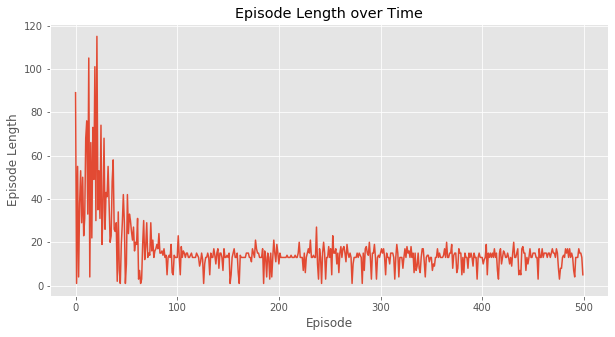

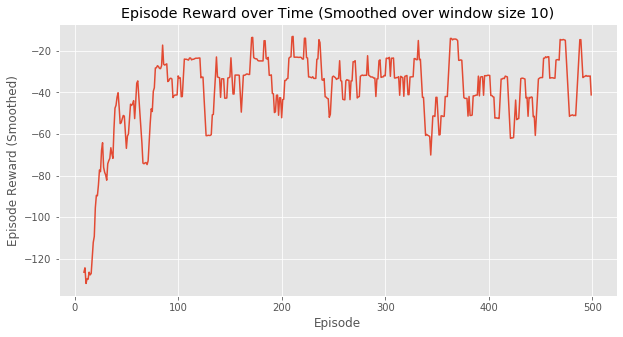

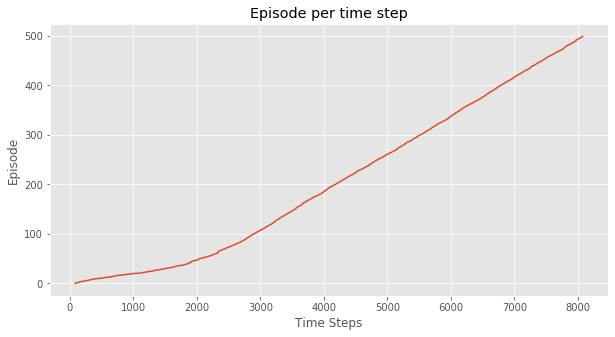

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [62]:
plotting.plot_episode_stats(stats)

### Testing out more ideas:
---
Variable alpha and GLIE

Results:
* As expected, GLIE converges way faster. 
* Using alpha as 1/num_times_seen doesn't seem to help here. 
* Constant alpha seems like a better option.

In [90]:
def q_learning_glie_varalpha(env, num_episodes, discount_factor=1, alpha=0.5, epsilon=0.1, glie=False, va=False):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    Testing out GLIE and variable alpha
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    if va:
        N = defaultdict(int)
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    if glie:
        epsilon = 1
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm.tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        while not done:
            action = np.random.choice(np.arange(env.action_space.n), p=policy(state))
            next_state, reward, done, info = env.step(action)
            
            # stats update
            stats.episode_lengths[i_episode] += 1
            stats.episode_rewards[i_episode] += reward
            
            # greedy action
            td_target = reward + discount_factor * np.max(Q[next_state])
            if va:
                N[(state, action)] += 1
                Q[state][action] += (1/N[(state, action)]) * (td_target - Q[state][action])
            else:
                Q[state][action] += alpha * (td_target - Q[state][action])
            
            state = next_state        
            if glie:
                policy = make_epsilon_greedy_policy(Q, 1/(i_episode + 1), env.action_space.n)
    
    return Q, stats

In [95]:
Q, stats = q_learning_glie_varalpha(env, 500, glie=True, va=False)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 550.60it/s]


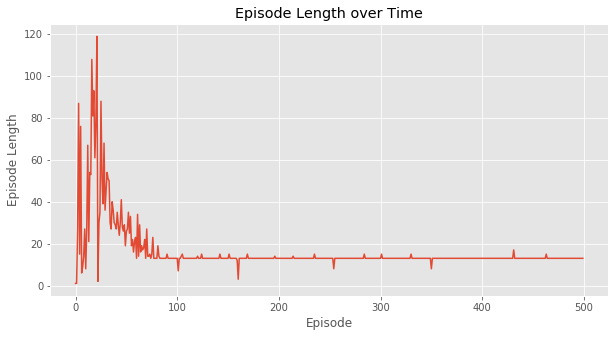

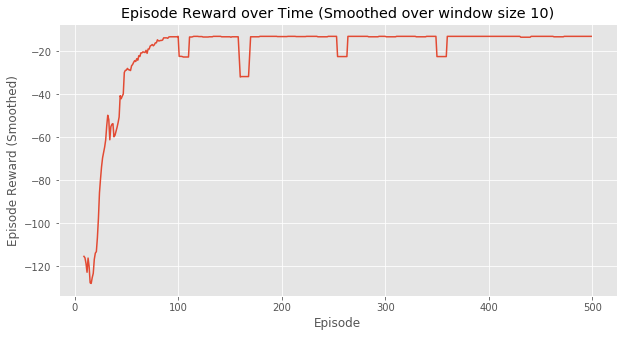

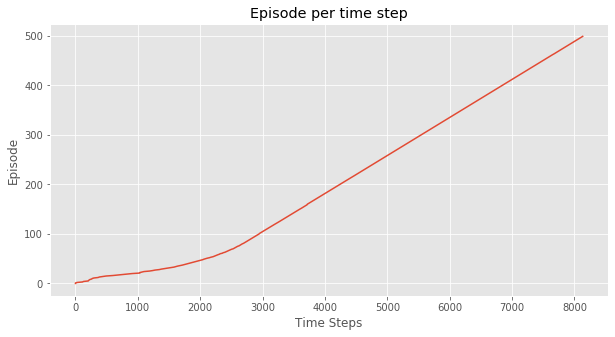

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [96]:
plotting.plot_episode_stats(stats)